In [1]:
import os
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf 
from IPython.display import Image
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.models import Sequential,Model, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,Activation, MaxPool2D ,Input, Average , concatenate, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_crossentropy
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint , CSVLogger , EarlyStopping 
from keras.layers import Conv2D, Flatten, Dense, Input, BatchNormalization, LeakyReLU, MaxPooling2D
from keras.models import Model

In [2]:
def one_hot_encode(arr):
    # Determine the number of categories (0 to 4)
    num_categories = 5
    
    # Use NumPy to create an array of zeros with the appropriate length
    one_hot_encoded = np.zeros((len(arr), num_categories))
    
    # Set the appropriate index for each number to 1
    for i, num in enumerate(arr):
        # Convert num to integer before using it as an index
        one_hot_encoded[i, int(num)] = 1
    
    return one_hot_encoded

In [3]:
def load_images_with_labels(main_directory, target_size=(224, 224), augment_data=False):
    class_directories = [d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d))]

    faces = []  # List to store processed images
    labels = []  # List to store corresponding labels

    label_to_index = {}  # Dictionary to map class names to integer labels
    index = 0

    for class_directory in class_directories:
        class_path = os.path.join(main_directory, class_directory)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        label_to_index[class_directory] = index

        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)  # Use OpenCV to read the image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            image = cv2.resize(image, target_size)  # Resize to target size
            image = image / 255.0  # Normalize pixel values

            faces.append(image)
            labels.append(index)

            if augment_data:
                # Apply data augmentation techniques

                # 1. Flipping horizontally
                flipped_image = cv2.flip(image, 1)
                faces.append(flipped_image)
                labels.append(index)

                # 2. Adding random noise
                noise = np.random.normal(0, 0.1, image.shape).astype(np.float32)
                noisy_image = np.clip(image + noise, 0, 1)
                faces.append(noisy_image)
                labels.append(index)

                # 3. Rotation (between -20 to 20 degrees)
                rows, cols, _ = image.shape
                rotation_angle = np.random.randint(-20, 21)
                rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
                rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
                faces.append(rotated_image)
                labels.append(index)


        index += 1

    return faces, labels

In [4]:
def load_images_with_labels_test(main_directory, target_size=(224, 224), augment_data=False):
    class_directories = [d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d))]

    faces = []  # List to store processed images
    labels = []  # List to store corresponding labels

    label_to_index = {}  # Dictionary to map class names to integer labels
    index = 0

    for class_directory in class_directories:
        class_path = os.path.join(main_directory, class_directory)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        label_to_index[class_directory] = index

        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)  # Use OpenCV to read the image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            image = cv2.resize(image, target_size)  # Resize to target size
            image = image / 255.0  # Normalize pixel values

            faces.append(image)
            labels.append(index)

        index += 1

    return faces, labels

In [5]:
dir1 = r'C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\data\Train\faces'

faces , faces_labels = load_images_with_labels(dir1)

In [6]:
dir2 = r'C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\data\Test\faces'

faces_test , faces_labels_test = load_images_with_labels_test(dir2)

In [7]:
dir3 = r'C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\data\Train\emotions'

emos , emos_labels  = load_images_with_labels(dir3)

In [8]:
dir4 = r'C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\data\Test\emotions'

emos_test , emos_labels_test = load_images_with_labels_test(dir4)

In [9]:
from sklearn.model_selection import train_test_split

# Splitting the images and labels into train and validation sets
faces_train, faces_val, faces_labels_train, faces_labels_val = train_test_split(faces, faces_labels, test_size=0.2, random_state=42)
emos_train, emos_val, emos_labels_train, emos_labels_val = train_test_split(emos, emos_labels, test_size=0.2, random_state=42)

In [10]:
# Convert lists to NumPy arrays and reshape
faces_train = np.array(faces_train)
faces_val = np.array(faces_val)
faces_test = np.array(faces_test)

emos_train = np.array(emos_train)
emos_val = np.array(emos_val)
emos_test = np.array(emos_test)


In [11]:
# Reshape input data if the first dimension corresponds to the batch size
faces_train = faces_train#.reshape((-1, 224, 224, 3))
faces_val = faces_val#.reshape((-1, 224, 224, 3))
faces_test = faces_test#.reshape((-1, 224, 224, 3))

emos_train = emos_train#.reshape((-1, 224, 224, 3))
emos_val = emos_val#.reshape((-1, 224, 224, 3))
emos_test = emos_test#.reshape((-1, 224, 224, 3))

faces_train = tf.convert_to_tensor(faces_train)
faces_val = tf.convert_to_tensor(faces_val)
faces_test = tf.convert_to_tensor(faces_test)

emos_train = tf.convert_to_tensor(emos_train)
emos_val = tf.convert_to_tensor(emos_val)
emos_test = tf.convert_to_tensor(emos_test)


In [12]:
# Convert lists to NumPy arrays and reshape
faces_labels_train = np.array(faces_labels_train)#.reshape((-1, 1))
faces_labels_val = np.array(faces_labels_val)#.reshape((-1, 1))
faces_labels_test = np.array(faces_labels_test)#.reshape((-1, 1))

emos_labels_train = np.array(emos_labels_train)#.reshape((-1, 1))
emos_labels_val = np.array(emos_labels_val)#.reshape((-1, 1))
emos_labels_test = np.array(emos_labels_test)#.reshape((-1, 1))

#convert to tensor
faces_labels_train = tf.convert_to_tensor(faces_labels_train)
faces_labels_val = tf.convert_to_tensor(faces_labels_val)
faces_labels_test = tf.convert_to_tensor(faces_labels_test)

emos_labels_train = tf.convert_to_tensor(emos_labels_train)
emos_labels_val = tf.convert_to_tensor(emos_labels_val)
emos_labels_test = tf.convert_to_tensor(emos_labels_test)

In [13]:
faces_labels_train_encoded = one_hot_encode(faces_labels_train)
faces_labels_val_encoded = one_hot_encode(faces_labels_val)
faces_labels_test_encoded = one_hot_encode(faces_labels_test)

emos_labels_train_encoded = one_hot_encode(emos_labels_train)
emos_labels_val_encoded = one_hot_encode(emos_labels_val)
emos_labels_test_encoded = one_hot_encode(emos_labels_test)

In [14]:
# Validate shapes and sizes
print(faces_train.shape, faces_labels_train_encoded.shape) 
print(emos_train.shape, emos_labels_train_encoded.shape) 
 
print(faces_test.shape, faces_labels_test_encoded.shape) 
print(emos_test.shape, emos_labels_test_encoded.shape)

(480, 224, 224, 3) (480, 5)
(480, 224, 224, 3) (480, 5)
(30, 224, 224, 3) (30, 5)
(30, 224, 224, 3) (30, 5)


In [15]:
# Define shared layers
shared_conv_1 = Conv2D(64, (3, 3), input_shape=(224, 224, 3))
shared_batch_norm_1 = BatchNormalization()
shared_leaky_relu_1 = LeakyReLU(alpha=0.1)
shared_max_pool_1 = MaxPooling2D(pool_size=(2, 2))

shared_conv_2 = Conv2D(128, (3, 3))
shared_batch_norm_2 = BatchNormalization()
shared_leaky_relu_2 = LeakyReLU(alpha=0.1)
shared_max_pool_2 = MaxPooling2D(pool_size=(2, 2))

shared_conv_3 = Conv2D(256, (3, 3))
shared_batch_norm_3 = BatchNormalization()
shared_leaky_relu_3 = LeakyReLU(alpha=0.1)
shared_max_pool_3 = MaxPooling2D(pool_size=(2, 2))

shared_flatten = Flatten()

# Define happy/sad classification task
happy_sad_input = Input(shape=(224, 224, 3), name='input_2')
x_happy_sad = shared_conv_1(happy_sad_input)
x_happy_sad = shared_batch_norm_1(x_happy_sad)
x_happy_sad = shared_leaky_relu_1(x_happy_sad)
x_happy_sad = shared_max_pool_1(x_happy_sad)

x_happy_sad = shared_conv_2(x_happy_sad)
x_happy_sad = shared_batch_norm_2(x_happy_sad)
x_happy_sad = shared_leaky_relu_2(x_happy_sad)
x_happy_sad = shared_max_pool_2(x_happy_sad)

x_happy_sad = shared_conv_3(x_happy_sad)
x_happy_sad = shared_batch_norm_3(x_happy_sad)
x_happy_sad = shared_leaky_relu_3(x_happy_sad)
x_happy_sad = shared_max_pool_3(x_happy_sad)

x_happy_sad = shared_flatten(x_happy_sad)
output_happy_sad = Dense(5, activation='softmax', name='happy_sad_output')(x_happy_sad)

# Define custom classification task
custom_input = Input(shape=(224, 224, 3), name='input_1')
x_custom = shared_conv_1(custom_input)
x_custom = shared_batch_norm_1(x_custom)
x_custom = shared_leaky_relu_1(x_custom)
x_custom = shared_max_pool_1(x_custom)

x_custom = shared_conv_2(x_custom)
x_custom = shared_batch_norm_2(x_custom)
x_custom = shared_leaky_relu_2(x_custom)
x_custom = shared_max_pool_2(x_custom)

x_custom = shared_conv_3(x_custom)
x_custom = shared_batch_norm_3(x_custom)
x_custom = shared_leaky_relu_3(x_custom)
x_custom = shared_max_pool_3(x_custom)

x_custom = shared_flatten(x_custom)
output_custom = Dense(5, activation='softmax', name='custom_output')(x_custom)

# Create the model
model = Model(inputs=[custom_input,happy_sad_input], outputs=[output_custom,output_happy_sad])

# Define the combined loss function
model.compile(optimizer='adam',
              loss={'custom_output': 'categorical_crossentropy', 'happy_sad_output': 'categorical_crossentropy'},
              loss_weights={'custom_output': 1.0, 'happy_sad_output': 1.0},
              metrics=['accuracy'])

# Set up callbacks
checkpoint_callback = ModelCheckpoint('model_weights.h5', save_best_only=True)
csv_logger_callback = CSVLogger('training.log')
# Define early stopping criteria
# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_custom_output_accuracy',  # Monitoring validation accuracy for 'custom_output'
    patience=4,  # Number of epochs with no improvement after which training will be stopped
    mode='max',  # Stopping criterion: maximize the monitored quantity (accuracy)
    verbose=1  # Provide verbose updates
)

In [16]:
history = model.fit({'input_1': faces_train, 'input_2': emos_train},
          {'custom_output': faces_labels_train_encoded, 'happy_sad_output': emos_labels_train_encoded},
          epochs=15,
          batch_size=16,
          validation_data=({'input_1': faces_val, 'input_2': emos_val},
                            {'custom_output': faces_labels_val_encoded, 'happy_sad_output': emos_labels_val_encoded}),
          callbacks=[checkpoint_callback, csv_logger_callback, early_stopping_callback])


Epoch 1/15
30/30 [==============================] - 107s 4s/step - loss: 35.3151 - custom_output_loss: 5.3075 - happy_sad_output_loss: 30.0076 - custom_output_accuracy: 0.8500 - happy_sad_output_accuracy: 0.2500 - val_loss: 33.0679 - val_custom_output_loss: 12.6647 - val_happy_sad_output_loss: 20.4033 - val_custom_output_accuracy: 0.2750 - val_happy_sad_output_accuracy: 0.2333
Epoch 2/15


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 114s 4s/step - loss: 14.9318 - custom_output_loss: 0.3867 - happy_sad_output_loss: 14.5451 - custom_output_accuracy: 0.9729 - happy_sad_output_accuracy: 0.4125 - val_loss: 63.1786 - val_custom_output_loss: 40.0956 - val_happy_sad_output_loss: 23.0830 - val_custom_output_accuracy: 0.2333 - val_happy_sad_output_accuracy: 0.2000
Epoch 3/15
30/30 [==============================] - 100s 3s/step - loss: 10.1432 - custom_output_loss: 0.0336 - happy_sad_output_loss: 10.1096 - custom_output_accuracy: 0.9937 - happy_sad_output_accuracy: 0.5375 - val_loss: 42.0683 - val_custom_output_loss: 23.1018 - val_happy_sad_output_loss: 18.9665 - val_custom_output_accuracy: 0.4167 - val_happy_sad_output_accuracy: 0.2167
Epoch 4/15
30/30 [==============================] - 93s 3s/step - loss: 8.1028 - custom_output_loss: 0.0939 - happy_sad_output_loss: 8.0090 - custom_output_accuracy: 0.9937 - happy_sad_output_accuracy: 0.5854 - val_loss: 57.6071 - val_custom_output_lo

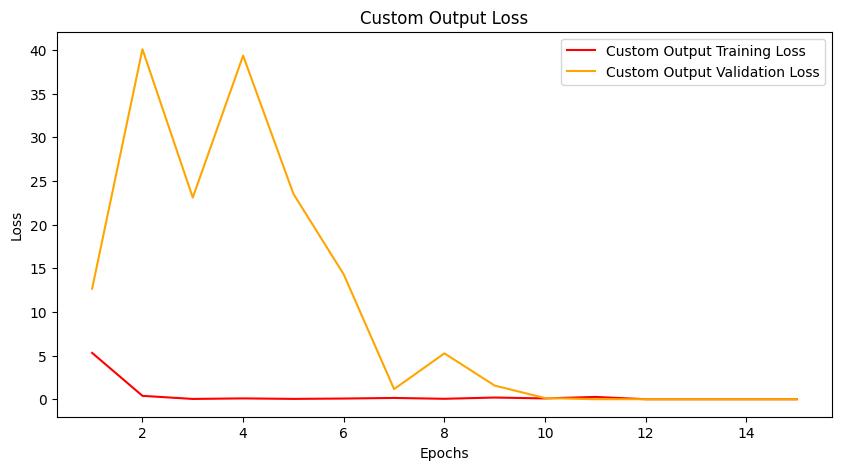

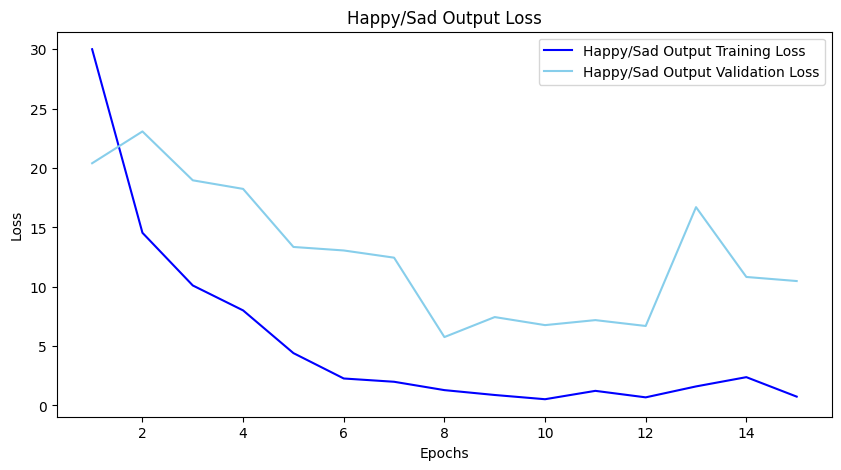

In [17]:
# Accessing loss and accuracy for each output
custom_output_loss = history.history['custom_output_loss']
happy_sad_output_loss = history.history['happy_sad_output_loss']

val_custom_output_loss = history.history['val_custom_output_loss']
val_happy_sad_output_loss = history.history['val_happy_sad_output_loss']

epochs = range(1, len(custom_output_loss) + 1)

# Plotting Custom Output Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, custom_output_loss, 'r', label='Custom Output Training Loss')
plt.plot(epochs, val_custom_output_loss, 'orange', label='Custom Output Validation Loss')
plt.title('Custom Output Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Happy/Sad Output Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, happy_sad_output_loss, 'b', label='Happy/Sad Output Training Loss')
plt.plot(epochs, val_happy_sad_output_loss, 'skyblue', label='Happy/Sad Output Validation Loss')
plt.title('Happy/Sad Output Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

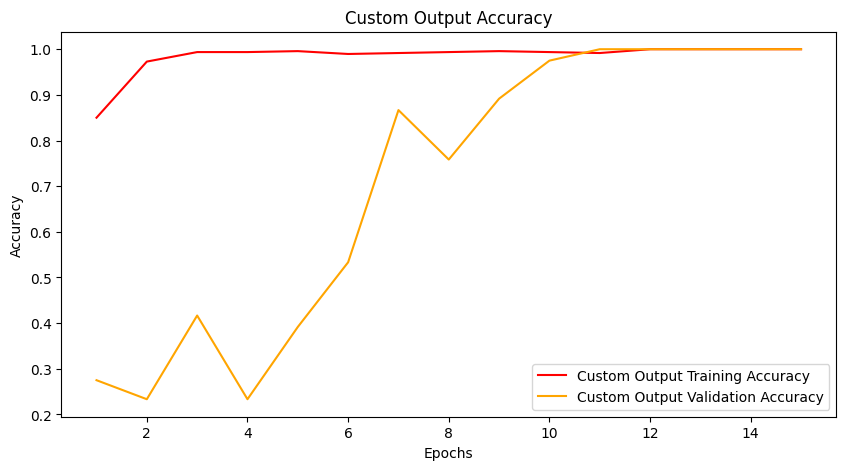

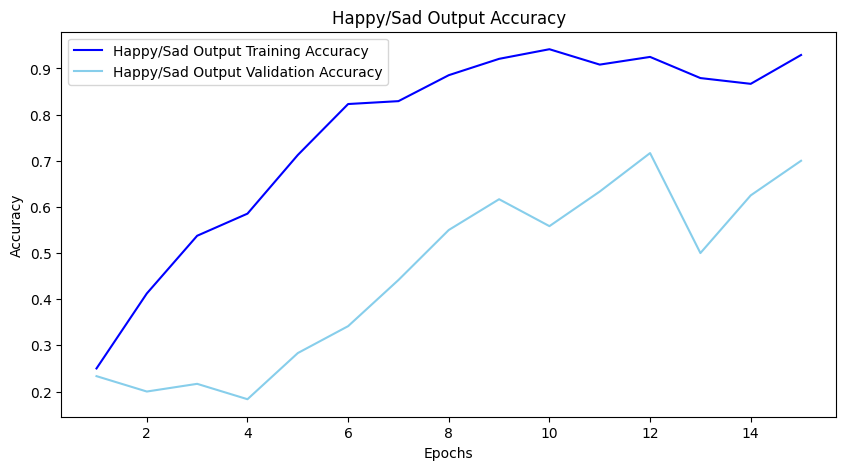

In [18]:
custom_output_acc = history.history['custom_output_accuracy']
happy_sad_output_acc = history.history['happy_sad_output_accuracy']

val_custom_output_acc = history.history['val_custom_output_accuracy']
val_happy_sad_output_acc = history.history['val_happy_sad_output_accuracy']

# Plotting Custom Output Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, custom_output_acc, 'r', label='Custom Output Training Accuracy')
plt.plot(epochs, val_custom_output_acc, 'orange', label='Custom Output Validation Accuracy')
plt.title('Custom Output Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Happy/Sad Output Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, happy_sad_output_acc, 'b', label='Happy/Sad Output Training Accuracy')
plt.plot(epochs, val_happy_sad_output_acc, 'skyblue', label='Happy/Sad Output Validation Accuracy')
plt.title('Happy/Sad Output Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
# Load the trained model
model =tf.keras.models.load_model(r'C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\model_best')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 64)         1792      ['input_2[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 222, 222, 64)         256       ['conv2d[0][0]',          

In [58]:
# Assuming 'model' is your trained model
evaluation = model.evaluate({'input_1': faces_test, 'input_2': emos_test},
                             {'custom_output': faces_labels_test_encoded, 'happy_sad_output': emos_labels_test_encoded})

1/1 [==============================] - 2s 2s/step - loss: 0.5955 - custom_output_loss: 0.0000e+00 - happy_sad_output_loss: 0.5955 - custom_output_accuracy: 1.0000 - happy_sad_output_accuracy: 0.9333


In [18]:
predictions = model.predict({'input_1': faces_test, 'input_2': emos_test})
# Assuming predictions are one-hot encoded, get the class with the highest probability
predicted_classes_reco = np.argmax(predictions[0], axis=1)
predicted_classes_emoji = np.argmax(predictions[1], axis=1)

# Get the actual classes from one-hot encoded labels
true_classes_reco = np.argmax(faces_labels_test_encoded, axis=1)
true_classes_emoji = np.argmax(emos_labels_test_encoded, axis=1)

# Calculate accuracy for each output
accuracy_reco = np.mean(predicted_classes_reco == true_classes_reco)
accuracy_emoji = np.mean(predicted_classes_emoji == true_classes_emoji)

print(f"Accuracy for reco output: {accuracy_reco}")
print(f"Accuracy for emoji output: {accuracy_emoji}")


1/1 [==============================] - 1s 1s/step
Accuracy for reco output: 1.0
Accuracy for emoji output: 0.9333333333333333


In [48]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1 , recall , precision

In [51]:
f , recall , precision =f1(true_classes_reco,predicted_classes_reco)
print(f'f-score {f} , precision {precision}  recall {recall}')

f-score 1.0 , precision 1.0  recall 1.0


In [52]:
f , recall , precision =f1(true_classes_emoji,predicted_classes_emoji)
print(f'f-score {f} , precision {precision}  recall {recall}')

f-score 0.9787233471870422 , precision 1.0  recall 0.9583333134651184


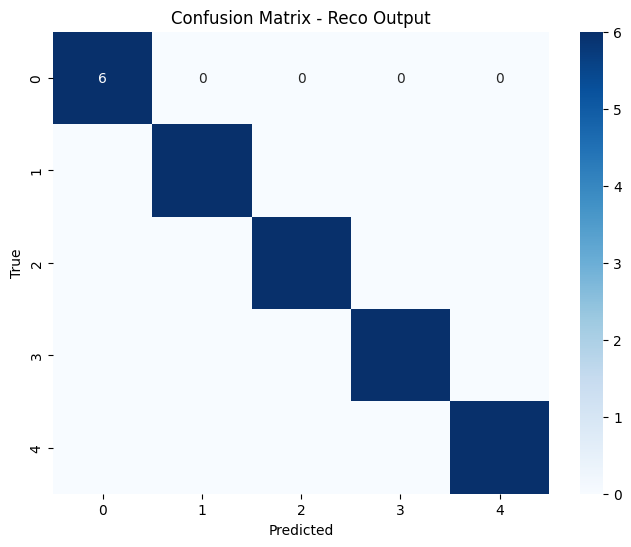

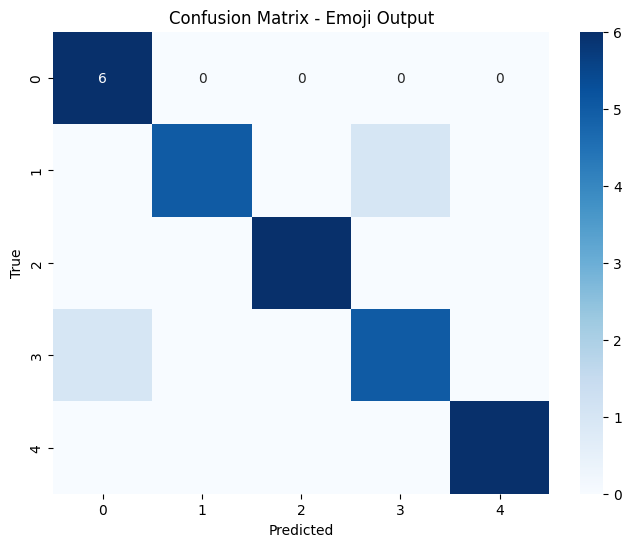

In [19]:
# Calculate confusion matrices
conf_matrix_reco = confusion_matrix(true_classes_reco, predicted_classes_reco)
conf_matrix_emoji = confusion_matrix(true_classes_emoji, predicted_classes_emoji)

# Plot confusion matrix for reco output
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_reco, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Reco Output')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot confusion matrix for emoji output
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_emoji, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Emoji Output')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
def emoji(x):
    if x==0:
        print('angry')
    elif x==1:
        print('happy')
    elif x==2:
        print('neutral')
    elif x==3:
        print('sad')
    elif x==4:
        print('surprised')

In [30]:
def reco(x):
    if x==0:
        print('aly')
    elif x==1:
        print('gomaa')
    elif x==2:
        print('mazen')
    elif x==3:
        print('omar')
    elif x==4:
        print('yassien')


In [56]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model  = tf.keras.models.load_model(r'C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\model_best')
# Function to convert prediction to emoji
def emoji1(x):
    if x==0:
        return 'angry'
    elif x==1:
        return 'happy'
    elif x==2:
        return 'neutral'
    elif x==3:
        return 'sad'
    elif x==4:
        return 'surprised'

def reco1(x):
    if x==0:
        return 'aly'
    elif x==1:
        return 'gomaa'
    elif x==2:
        return 'mazen'
    elif x==3:
        return 'omar'
    elif x==4:
        return 'yassien'
   
        
# Open the default camera (usually 0)
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.flip(frame,1) 

    # Perform any necessary preprocessing on the frame (resize, normalization, etc.)
    preprocessed_frame = cv2.resize(frame, (224, 224))  # Adjust size to match model input shape
    preprocessed_frame = preprocessed_frame / 255.0  # Normalize pixel values to [0, 1]

    # Make predictions using the model
    predictions = model.predict([np.expand_dims(preprocessed_frame, axis=0), np.expand_dims(preprocessed_frame, axis=0)])

    # Extract relevant information from predictions
    happy_sad_prediction = np.argmax(predictions[0])
    custom_prediction = np.argmax(predictions[1])
    happy_sad_prediction = emoji1(happy_sad_prediction)
    custom_prediction = reco1(custom_prediction)

    # Display predictions as an overlay inside the video frame
    overlay = frame.copy()
    cv2.putText(frame, f'emoji: {happy_sad_prediction}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(frame, f'person: {custom_prediction}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Blend the overlay with the original frame
    alpha = 0.5  # Adjust the alpha value for the blending
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    # Display the resulting frame
    cv2.imshow('Frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 94ms/step


gomaa
happy


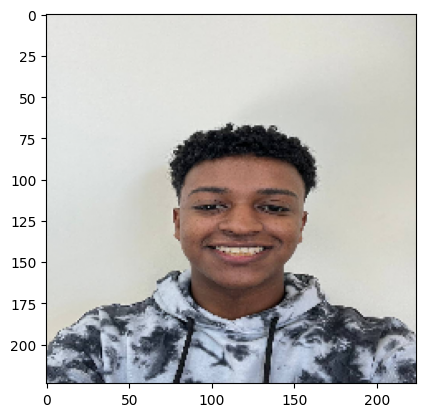

In [32]:
y=7
plt.imshow(faces_test[y])
reco(predicted_classes_reco[y])
emoji(predicted_classes_emoji[y])

mazen
neutral


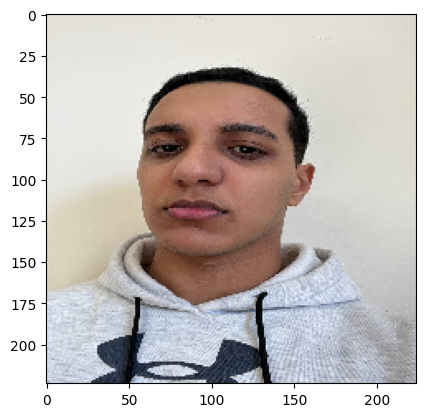

In [33]:
y=15
plt.imshow(faces_test[y])
reco(predicted_classes_reco[y])
emoji(predicted_classes_emoji[y])

aly
angry


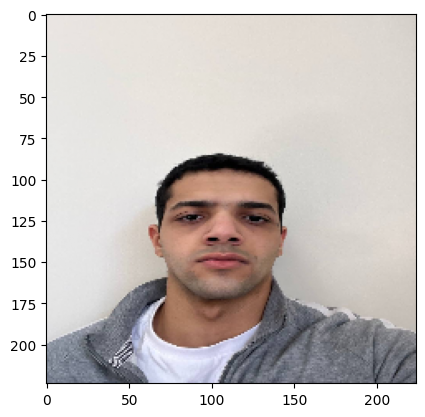

In [34]:
y=1
plt.imshow(faces_test[y])
reco(predicted_classes_reco[y])
emoji(predicted_classes_emoji[y])

yassien
surprised


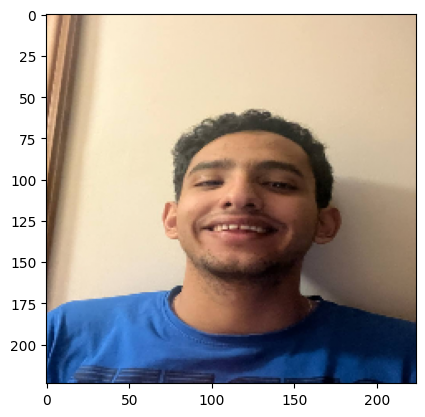

In [35]:
y=27
plt.imshow(faces_test[y])
reco(predicted_classes_reco[y])
emoji(predicted_classes_emoji[y])

omar
sad


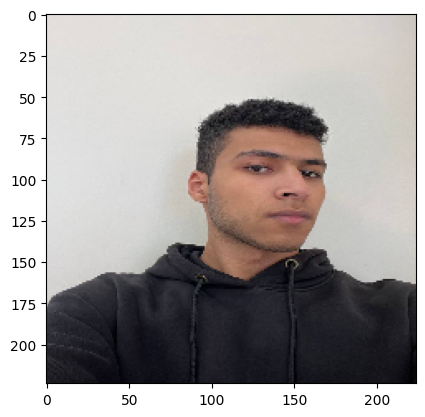

In [36]:
y=22
plt.imshow(faces_test[y])
reco(predicted_classes_reco[y])
emoji(predicted_classes_emoji[y])

In [37]:
model.save_weights(r"C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\weights_best_model.h5")

In [39]:
model.save(r'C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\model_best')

INFO:tensorflow:Assets written to: C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\model_best\assets


INFO:tensorflow:Assets written to: C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\model_best\assets


In [40]:
weights =tf.keras.models.load_model(r'C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\model_best')

In [46]:
weights.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 64)         1792      ['input_2[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 222, 222, 64)         256       ['conv2d[0][0]',          

In [ ]:
model.load_weights(r"C:\Users\User\Desktop\koleya\level3 term 1\deep learning\project\weights_best_model.h5")